# Purpose: 
Generate a fire perimeter in GeoJSON based on the input pre and post flight images

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/uavsar-main/python").resolve()
sys.path.append(str(utils_path))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from process_utils import (preprocess_data, 
                           superpixel_segmentation,
                           get_superpixel_model_labels,get_model_labels,
                           convert_labels_to_gdf,
                           filter_by_area,
                           merge_geojson,
                           tv_denoise,)
from nd_utils import (get_superpixel_means_as_features,
                      get_superpixel_stds_as_features,get_superpixel_medians_as_features,
                      get_array_from_features)
# # from process_utils import (preprocess_data, 
#                            get_model_labels)
from rio_utils import (reproject_arr_to_match_profile)
from shapely.geometry import Polygon
from shapely.geometry import Point
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the preprocessed images
- `superpixel_labels_list` (list): a list containing the paths to the superpixel labels

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
        transform = ds.transform
    return band, profile, transform

In [4]:
# # Path to the folder with the preprocessed images
# data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/data_output_HV_logratio")

# tifs = sorted(list(data_dir.glob('./*before_imputed_*.tif')))
# tifs

---
Open the preprocessed images and load the superpixel segmentation corresponded to the pre- and post- fire.

- Let `hv_0` correspond to the pre-fire image and `hv_1` correspond to the post-fire image. 
- Let `profile` and `transform` correspond to the pre-fire image.
- Let `superpixel_labels` be the output of the segmentation

In [5]:
# # open the tifs
# bands_tv, profiles, transforms = zip(*map(open_one, tifs))
# hv_0 = bands_tv[0]
# hv_1 = bands_tv[1]
# profile = profiles[0]
# transform = transforms[0]

In [6]:
# hv_0 = denoise(hv_0,5)
# hv_1 = denoise(hv_1,5)

---
This is the preprocessed raster image we will work with to extract the fire perimeter

In [7]:
# # compute log ratio and filter out the vegetation gain by setting to no change.
# log_ratio = 10*np.log10(hv_0/hv_1)

In [8]:
# plt.imshow(log_ratio)

In [9]:
# Load if we have performed segmentation previously
superpixel_labels = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Opera_sentinel1_rtc_merged/superpixel_labels_operal_sentine1_230727_231017_min50.npy")

In [10]:
print("superpizel_labels: ")
print(superpixel_labels)

superpizel_labels: 
[[   0    0    0 ...   95   95   95]
 [   0    0    0 ...   95   95   95]
 [   0    0    0 ...   96   96   96]
 ...
 [2413 2413 2413 ... 2386 2386 2386]
 [2413 2413 2413 ... 2386 2386 2386]
 [2413 2413 2418 ... 2386 2386 2386]]


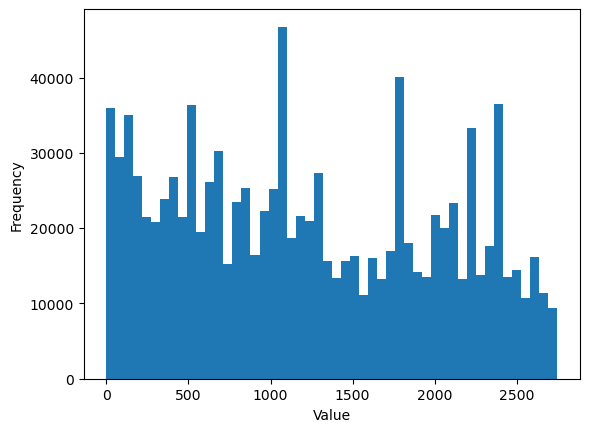

In [11]:
# Check the distribution of the data
plt.hist(superpixel_labels.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Classification

In [12]:
# pre_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Pre_alpha_perimeter_data/pre_merged_alpha1_image_test_before_imputed.npy")
# post_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/post_merged_alpha_image_test_aligned_before_imputed.npy")
# slope = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Slope/slope_aligned.npy")

In [13]:
opera_sentinel1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/final_merged_image.npy")

In [14]:
print("Opera_Sentinel1", opera_sentinel1.shape)

Opera_Sentinel1 (1007, 1069)


In [15]:
# print("pre_alpha1", pre_alpha1.shape)

In [16]:
# print("post_alpha1", post_alpha1.shape)

In [17]:
# print("slope", slope.shape)

In [18]:
# np.seterr(divide='ignore', invalid='ignore')
# #Extracting features
# mean_log_ratio = get_superpixel_means_as_features(superpixel_labels, log_ratio)
# median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels, pre_alpha1)
# median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels, post_alpha1)
# diff_alpha1 = median_pre_alpha1 - median_post_alpha1
# median_slope = get_superpixel_medians_as_features(superpixel_labels, slope)
# mean_slope = get_superpixel_means_as_features(superpixel_labels, slope)


In [19]:
opera_sentinel1 = get_superpixel_medians_as_features(superpixel_labels, opera_sentinel1)

In [20]:
unique_superpixel_labels = np.unique(superpixel_labels)
unique_superpixel_labels_reshape = unique_superpixel_labels.reshape(-1,1)


In [21]:
print(unique_superpixel_labels_reshape.shape)

(2745, 1)


In [22]:
print(opera_sentinel1.shape)

(2745, 1)


In [23]:
# I need to check how to make a dataframe using these columns
fire_data = np.hstack([unique_superpixel_labels_reshape, opera_sentinel1])

In [24]:
# # I need to check how to make a dataframe using these columns
# fire_data = np.hstack([unique_superpixel_labels_reshape,mean_log_ratio, diff_alpha1, median_slope])

In [25]:
import pandas as pd
# Create pandas dataframe with column names
df = pd.DataFrame(fire_data, columns=['superpixel_label', 'opera_sentinel1'])
print(df)

      superpixel_label  opera_sentinel1
0                  0.0              NaN
1                  1.0              NaN
2                  2.0              NaN
3                  3.0              NaN
4                  4.0              NaN
...                ...              ...
2740            2740.0              NaN
2741            2741.0              NaN
2742            2742.0              NaN
2743            2743.0              NaN
2744            2744.0              NaN

[2745 rows x 2 columns]


In [26]:
# Calculate the number of non-null values in each row
non_null_counts = df.count(axis=1)

# Get the total number of columns
num_columns = df.shape[1]

# Determine complete rows
complete_rows = df[non_null_counts == num_columns]

# Count the number of complete rows
num_complete_rows = len(complete_rows)
print(num_complete_rows)

1081


In [27]:
# retain only complete rows
df_cleaned = df.dropna()
print(len(df_cleaned))
#pd.set_option('display.max_rows',None)
print(df_cleaned)

1081
      superpixel_label  opera_sentinel1
18                18.0         0.034743
19                19.0         0.020899
21                21.0         0.021765
113              113.0         0.021607
116              116.0         0.028097
...                ...              ...
2699            2699.0         0.059179
2702            2702.0         0.069004
2723            2723.0         0.055958
2726            2726.0         0.058257
2732            2732.0         0.058618

[1081 rows x 2 columns]


In [28]:
df_cleaned_for_model = df_cleaned.drop('superpixel_label', axis=1) # we don't want to use the superpixel label as a feature
print(df_cleaned_for_model)

      opera_sentinel1
18           0.034743
19           0.020899
21           0.021765
113          0.021607
116          0.028097
...               ...
2699         0.059179
2702         0.069004
2723         0.055958
2726         0.058257
2732         0.058618

[1081 rows x 1 columns]


Other Hyperparameter Values for K-means

In [29]:
from sklearn.cluster import KMeans

model = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=1e-4,
    algorithm='elkan',
    random_state=42
)
classes = get_superpixel_model_labels(df_cleaned_for_model, model)
classes = classes + 1
classes

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

In [30]:
# from sklearn.cluster import AgglomerativeClustering

# agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
# classes = agg.fit_predict(df_cleaned_for_model) + 1
# classes

In [31]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(
#     n_components=4,
#     covariance_type='full',
#     random_state=42
# )
# classes = gmm.fit_predict(df_cleaned_for_model) + 1
# classes

In [32]:
print(np.unique(classes))

[1 2 3 4]


In [33]:
# print(len(classes))

print(df_cleaned.shape)

(1081, 2)


In [34]:
# Dr.Uma Code
model_output = superpixel_labels
# model_output = np.empty_like(superpixel_labels)
# model_output[:] = 0 # 0 indicates missing values since classes are numbered 1, 2, ...

for i in range(len(classes)):
    # print(i)
    # print(df_cleaned.iat[i,0])
    # print(classes[i])
    model_output[model_output==int(df_cleaned.iat[i,0])] = classes[i]
    # model_output = np.where(model_output == int(df_cleaned.iat[i,0]),classes[i],0) # logically this is correct
    # np.put(model_output,np.where(model_output==int(df_cleaned.iat[i,0])),classes[i])
    # model_output.replace(df_cleaned.iat[i,0],classes[i])
# print(superpixel_labels)
# print(model_output)

In [35]:
print(model_output)

[[   0    0    0 ...   95   95   95]
 [   0    0    0 ...   95   95   95]
 [   0    0    0 ...   96   96   96]
 ...
 [2413 2413 2413 ... 2386 2386 2386]
 [2413 2413 2413 ... 2386 2386 2386]
 [2413 2413 2418 ... 2386 2386 2386]]


In [36]:
#print(np.unique(model_output))
print(type(model_output))

<class 'numpy.ndarray'>


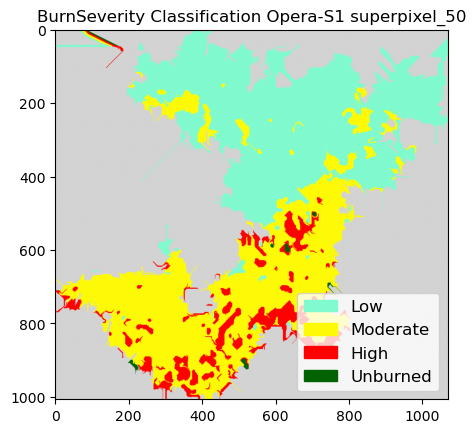

In [41]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
colors = ['lightgray'] * 10  # A default color for other values
colors[1] = '#80face'
colors[2] = '#fefa07'
colors[3] = '#fc0200'
colors[4] = '#036201'
# Unburned to Low: HEX #036201
# Low: #80face
# Moderate: #fefa07
# High: #fc0200
class_names = {
    1: "Low",
    2: "Moderate",
    3: "High",
    4: "Unburned"
}

cmap = mcolors.ListedColormap(colors)

bounds = np.arange(len(colors) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

legend_patches = [
    mpatches.Patch(color=colors[i], label=class_names[i]) for i in class_names
 ]

plt.imshow(model_output, cmap=cmap, norm=norm)
# plt.colorbar(ticks=np.arange(len(colors))) # Add a colorbar for reference
plt.title('BurnSeverity Classification Opera-S1 superpixel_50')
plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()